# Análise de Variância (ANOVA) Quais Fatores Tem Maior Impacto no Salário de Um Funcionário?

O objetivo deste estudo de caso é Analisar <b>Quais Fatores Tem Maior Impacto no Salário de Um Funcionário?</b>

Faremos a análise de um conjunto de dados com diversas variáveis de funcionários de uma empresa. 
Fatores como idade, educação, função, viagens a trabalho, horas extras, entre outros, fazem parte do dataset.

Este estudo de caso está dividido em duas partes: Na Parte 1 (esta que você está agora) aplicaremos ANOVA para analisar somente as variáveis categóricas do dataset.

Na Parte 2 aplicaremos um modelo de Regressão Linear para analisar todas as variáveis, quantitativas e categóricas.

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Scipy

# Pingouin
from scipy import stats
import pingouin as pg
# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 200)
plt.rcParams["figure.figsize"] = (20,10)

## Import do Dataset

In [2]:
salarios = pd.read_csv('dataset.csv')

print(salarios.shape)

salarios.head()

(1470, 35)


,Idade,Atrito,ViagemNegocios,TaxaDiaria,Departmento,DistanciaCasa,Educacao,CampoEducacao,ContagemEmpregado,NumeroEmpregado,SatisfacaoAmbiente,Sexo,ValorHora,EnvolvimentoTrabalho,NivelTrabalho,Funcao,SatisfacaoTrabalho,EstadoCivil,SalarioMensal,TaxaMensal,NumEmpresasTrabalhou,Acima18,HoraExtra,AumentoPercentualSalario,AvaliacaoPerformance,SatisfacaoRelacionamento,HorasPadroes,NivelOpcoesAcoes,TotalAnosTrabalho,NumTreinamentosAnoAnterior,EquilibrioVidaPessoal,AnosEmpresa,AnosFuncaoAtual,AnosDesdeUltimaPromocao,AnosGerenteAtual
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
# Eliminamos variáveis que não serão relevantes para o estudo

col_drop = ['Acima18', 'HoraExtra', 'NumeroEmpregado', 'ContagemEmpregado']

salarios.drop(columns=col_drop, inplace=True)

salarios.shape

(1470, 31)

## Relatório de Análise - Estudo de Caso

Nosso trabalho é descobrir quais fatores tem maior impacto no salário de um funcionário. 

Usaremos 'SalarioMensal' como variável de resposta porque essa variável representa a renda mensal.

Antes de começar a analisar, eliminamos algumas variáveis do dataset porque elas tinham apenas um valor e não havia variação nelas.

Aqui usaremos um modelo ANOVA somente com as variáveis categóricas como preditores.

Na parte II aplicaremos Regressão Linear ao mesmo problema.

Vamos iniciar o trabalho analisando nossa variável target 'SalarioMensal'.

## Checando se a variável SalarioMensal segue uma distribuição normal.

In [4]:
# Teste de normalidade

# Shapiro-Wilk test
display(pg.normality(salarios['SalarioMensal']))

,W,pval,normal
SalarioMensal,0.827908,4.403175e-37,False


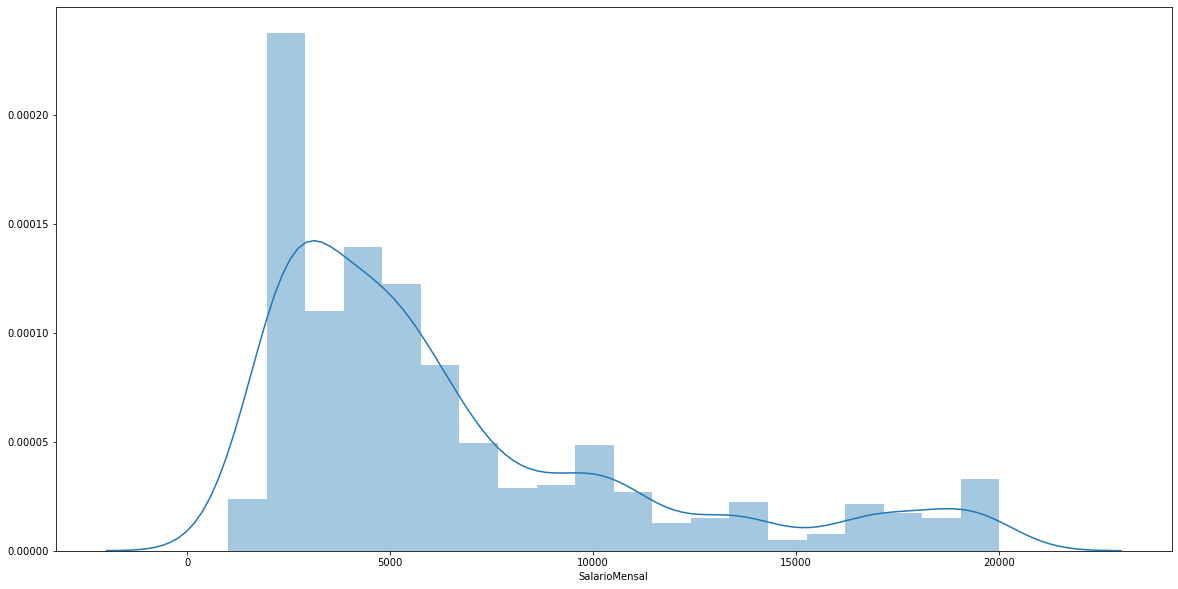

In [5]:
# Histograma
sns.distplot(salarios['SalarioMensal'])

A qualidade do ajuste e do teste de normalidade mostra que SalarioMensal não segue a distribuição normal.

Talvez tenhamos que transformar a variável quando trabalharmos com regressão.

## ANOVA

Vamos criar duas versões do modelo. 

- Na primeira versão usaremos todas as variáveis categóricas no dataset. 
- Na segunda versão usaremos as variáveis mais significativas ss1 e ss3.

O QQplot parece seguir a distribuição normal. Parece haver uma variação um pouco decrescente nos resíduos à medida que o valor previsto aumenta, mas ainda está bom e, portanto, não precisamos usar a transformação.


### Funcoes de Apoio

In [6]:
def diagnostic_plots(X, y, model_fit=None):
    from statsmodels.graphics.gofplots import ProbPlot
    """
    Function to reproduce the 4 base plots of an OLS model in R.
	
    ---
    Inputs:
	
    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
	
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model
	
    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                          generated from X, y
    """
	
    if not model_fit:
          model_fit = sm.OLS(y, sm.add_constant(X)).fit()
	
    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
	
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
	
    fig = plt.figure()
    
    plot_lm_1 = fig.add_subplot(331)
    sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.set_title('Residuals vs Fitted')
    plot_lm_1.set_xlabel('Fitted values')
    plot_lm_1.set_ylabel('Residuals');
	# annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.annotate(i, xy=(model_fitted_y[i], model_residuals[i]));
	
    ax = fig.add_subplot(332)
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
    plot_lm_2.axes[1].set_title('Normal Q-Q')
    plot_lm_2.axes[1].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[1].set_ylabel('Standardized Residuals');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[1].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r], model_norm_residuals[i]));
	
    plot_lm_3 = fig.add_subplot(333)
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.set_title('Scale-Location')
    plot_lm_3.set_xlabel('Fitted values')
    plot_lm_3.set_ylabel('$\sqrt{|Standardized Residuals|}$');
	# annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
	
	
    plot_lm_4 = fig.add_subplot(334)
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, model_norm_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.set_ylim(-3, 5)
    plot_lm_4.set_title('Residuals vs Leverage')
    plot_lm_4.set_xlabel('Leverage')
    plot_lm_4.set_ylabel('Standardized Residuals');
	# annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
    
    plot_lm_5 = fig.add_subplot(335)
    sns.regplot(y=y, x=model_fitted_y, color='green', ax=plot_lm_5)
    plt.ylim(0)
    plt.xlim(0)
    plt.title('Residual vs Predicted')
    plt.ylabel('SalarioMensal')
    plt.xlabel('Predicted Value')
    
    fig.tight_layout()
	

In [7]:
# Essa função pode ser encontrada em https://github.com/jcabralc/ml-utils
'''
ANOVA
Show information about the dataset and most relevante features

Parameters:
    df: Dataset to Analyse
    features: List of Features to Analyse
    dep_feature: Dependence Feature
    frac = Fraction of Data in Dataset to Analyse. Default is 1.0 (100%, all the data)
    random_state = Default is 1
    anova_form = Formula to fit the Linear Model
    ss_type = Squares Type (1, 2 or 3). Int or List of ints
    
The Sum of Squares Type I (SS1) allows to verify if the inclusion of additional variables in the model represents a significant marginal contribution;
The Sum of Squares Type III (SS3) allows to verify, considering all the other explanatory variables of the model, the marginal contribution of a variable is significant;
'''
def ANOVA_diagnostics(df, features, dep_feature, anova_form, ss_type, frac=1.0, random_state=1):
    from pandas import DataFrame
    # colect sample os data based on frac parameter
    frac_df = df.sample(frac=frac,  random_state= random_state)
    # Create Class Level Information Table
    print('------ Class Level Information Table ------ \n')
    Class_Level_Information = DataFrame(columns=['Class', 'Levels', 'Values'])
    # Colect info for each feature
    for idx, feat in enumerate(features):
        Class_Level_Information.loc[idx, 'Class'] = feat
        Class_Level_Information.loc[idx, 'Levels'] = len(DataFrame(frac_df[feat].value_counts()).index)
        Class_Level_Information.loc[idx, 'Values'] = DataFrame(frac_df[feat].value_counts()).index.tolist()
    display(Class_Level_Information)
    # Show Observations Read/Used
    display(DataFrame({'Number of Observations Read': df.shape[0], 
                       'Number of Observations Used': [frac_df.shape[0]]}).T)
    # info from the Dependent Variable
    print('\n------ Dependent Variable: {} ------ '.format(dep_feature))
    # ANOVA
    moore_lm = ols(anova_form, data=frac_df).fit()
    print('\n------ Model Statistics ------ ')
    display(moore_lm.summary())
    if (type(ss_type) == list):
        for typ in ss_type:
            print('\n ------ ANOVA Type {} SS ------ '.format(typ))
            anova_table = sm.stats.anova_lm(moore_lm, typ=typ)
            display(anova_table)
            print('------  Most significant variables based on SS ------ ')
            display(anova_table.sort_values(by='sum_sq', ascending=False)[:5])
            
    
    print('\n------ Diagnostic Plots ------ ')
    diagnostic_plots(frac_df[features], frac_df[dep_feature], model_fit=moore_lm)
    
    
    
    

### ANOVA Modelo 1


------ Class Level Information Table ------ 



,Class,Levels,Values
0,ViagemNegocios,3,"[Travel_Rarely, Travel_Frequently, Non-Travel]"
1,NivelTrabalho,5,"[1, 2, 3, 4, 5]"
2,Departmento,3,"[Research & Development, Sales, Human Resources]"
3,Atrito,2,"[No, Yes]"
4,CampoEducacao,6,"[Life Sciences, Medical, Marketing, Technical Degree, Other, Human Resources]"
5,Sexo,2,"[Male, Female]"
6,Funcao,8,"[Research, Sales Executive, Laboratory Technician, Manufacturing Director, Healthcare Representative, Manager, Sales Representative, Human Resources]"
7,EstadoCivil,3,"[Married, Single, Divorced]"
8,Educacao,5,"[3, 4, 2, 1, 5]"
9,SatisfacaoAmbiente,4,"[3, 4, 2, 1]"


,0
Number of Observations Read,1470
Number of Observations Used,1470



------ Dependent Variable: SalarioMensal ------ 

------ Model Statistics ------ 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalarioMensal   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     419.1
Date:                Sat, 04 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:12:35   Log-Likelihood:                -12534.
No. Observations:                1470   AIC:                         2.516e+04
Df Residuals:                    1422   BIC:                         2.542e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 2784.1077    557.822      4.991      0.000    1689.866    3878.349
C(ViagemNegocios)[T.Travel_Frequently]      61.8600    128.529      0.481      0.630    -190.267     313.987
C(ViagemNegocios)[T.Travel_Rarely]         131.5034    110.550      1.190      0.234     -85.355     348.362
C(NivelTrabalho)[T.2]                     2761.2180    112.923     24.452      0.000    2539.705    2982.731
C(NivelTrabalho)[T.3]                     6951.4980    132.882     52.313      0.000    6690.833    7212.163
C(NivelTrabalho)[T.4]                     1.192e+04    166.653     71.533      0.000    1.16e+04    1.22e+04
C(NivelTrabalho)[T.5]                     1.524e+04    201.014     75.808      0.000    1.48e+04    1.56e+04
C(Departmento)[T.Research & Development]   574.1178    451.305      1.272      0.204    -311.177    1459.412
C(Departmento)[T.Sales]                    432.8256    469.416      0.922      0.357    -487.997    1353.648
C(Atrito)[T.Yes]                          -140.8730     98.110     -1.436      0.151    -333.330      51.584
C(CampoEducacao)[T.Life Sciences]         -170.8356    324.947     -0.526      0.599    -808.263     466.592
C(CampoEducacao)[T.Marketing]             -151.6064    345.856     -0.438      0.661    -830.049     526.836
C(CampoEducacao)[T.Medical]               -113.5003    326.013     -0.348      0.728    -753.018     526.017
C(CampoEducacao)[T.Other]                 -236.9183    349.794     -0.677      0.498    -923.086     449.249
C(CampoEducacao)[T.Technical Degree]      -184.3161    338.829     -0.544      0.587    -848.974     480.342
C(Sexo)[T.Male]                             38.5828     67.146      0.575      0.566     -93.134     170.300
C(Funcao)[T.Human Resources]               544.6450    471.115      1.156      0.248    -379.510    1468.800
C(Funcao)[T.Laboratory Technician]        -147.0205    157.814     -0.932      0.352    -456.593     162.552
C(Funcao)[T.Manager]                      1807.5590    233.673      7.735      0.000    1349.179    2265.939
C(Funcao)[T.Manufacturing Director]       -104.4569    150.785     -0.693      0.489    -400.241     191.327
C(Funcao)[T.Research]                      430.3361    146.562      2.936      0.003     142.836     717.836
C(Funcao)[T.Sales Executive]               198.9399    297.897      0.668      0.504    -385.425     783.305
C(Funcao)[T.Sales Representative]         -128.9857    335.814     -0.384      0.701    -787.730     529.759
C(EstadoCivil)[T.Married]                   16.4760     89.025      0.185      0.853    -158.159     191.111
C(EstadoCivil)[T.Single]                   -57.0418    143.980     -0.396      0.692    -339.477     225.394
C(Educacao)[T.2]               


 ------ ANOVA Type 1 SS ------ 


,df,sum_sq,mean_sq,F,PR(>F)
C(ViagemNegocios),2.0,4.941757e+07,2.470879e+07,16.025934,1.310102e-07
C(NivelTrabalho),4.0,3.007898e+10,7.519746e+09,4877.250873,0.000000e+00
C(Departmento),2.0,1.454198e+06,7.270990e+05,0.471591,6.241063e-01
C(Atrito),1.0,6.048019e+06,6.048019e+06,3.922700,4.783075e-02
C(CampoEducacao),5.0,1.707626e+06,3.415252e+05,0.221511,9.533673e-01
C(Sexo),1.0,2.229528e+05,2.229528e+05,0.144606,7.038016e-01
C(Funcao),7.0,1.893789e+08,2.705414e+07,17.547110,1.981665e-22
C(EstadoCivil),2.0,2.034285e+06,1.017142e+06,0.659711,5.171589e-01
C(Educacao),4.0,1.340109e+07,3.350272e+06,2.172961,6.985654e-02
C(SatisfacaoAmbiente),3.0,1.372974e+06,4.576580e+05,0.296834,8.277113e-01


------  Most significant variables based on SS ------ 


,df,sum_sq,mean_sq,F,PR(>F)
C(NivelTrabalho),4.0,3.007898e+10,7.519746e+09,4877.250873,0.000000e+00
Residual,1422.0,2.192440e+09,1.541800e+06,NaN,NaN
C(Funcao),7.0,1.893789e+08,2.705414e+07,17.547110,1.981665e-22
C(ViagemNegocios),2.0,4.941757e+07,2.470879e+07,16.025934,1.310102e-07
C(Educacao),4.0,1.340109e+07,3.350272e+06,2.172961,6.985654e-02



 ------ ANOVA Type 3 SS ------ 


,sum_sq,df,F,PR(>F)
Intercept,3.840691e+07,1.0,24.910438,6.746922e-07
C(ViagemNegocios),2.806475e+06,2.0,0.910129,4.027065e-01
C(NivelTrabalho),1.357256e+10,4.0,2200.765425,0.000000e+00
C(Departmento),2.573877e+06,2.0,0.834699,4.342177e-01
C(Atrito),3.178729e+06,1.0,2.061700,1.512615e-01
C(CampoEducacao),1.925336e+06,5.0,0.249752,9.400386e-01
C(Sexo),5.090608e+05,1.0,0.330173,5.656481e-01
C(Funcao),1.856763e+08,7.0,17.204035,5.728364e-22
C(EstadoCivil),6.573646e+05,2.0,0.213181,8.080358e-01
C(Educacao),1.315019e+07,4.0,2.132278,7.459644e-02


------  Most significant variables based on SS ------ 


,sum_sq,df,F,PR(>F)
C(NivelTrabalho),1.357256e+10,4.0,2200.765425,0.000000e+00
Residual,2.192440e+09,1422.0,NaN,NaN
C(Funcao),1.856763e+08,7.0,17.204035,5.728364e-22
Intercept,3.840691e+07,1.0,24.910438,6.746922e-07
C(Educacao),1.315019e+07,4.0,2.132278,7.459644e-02



------ Diagnostic Plots ------ 


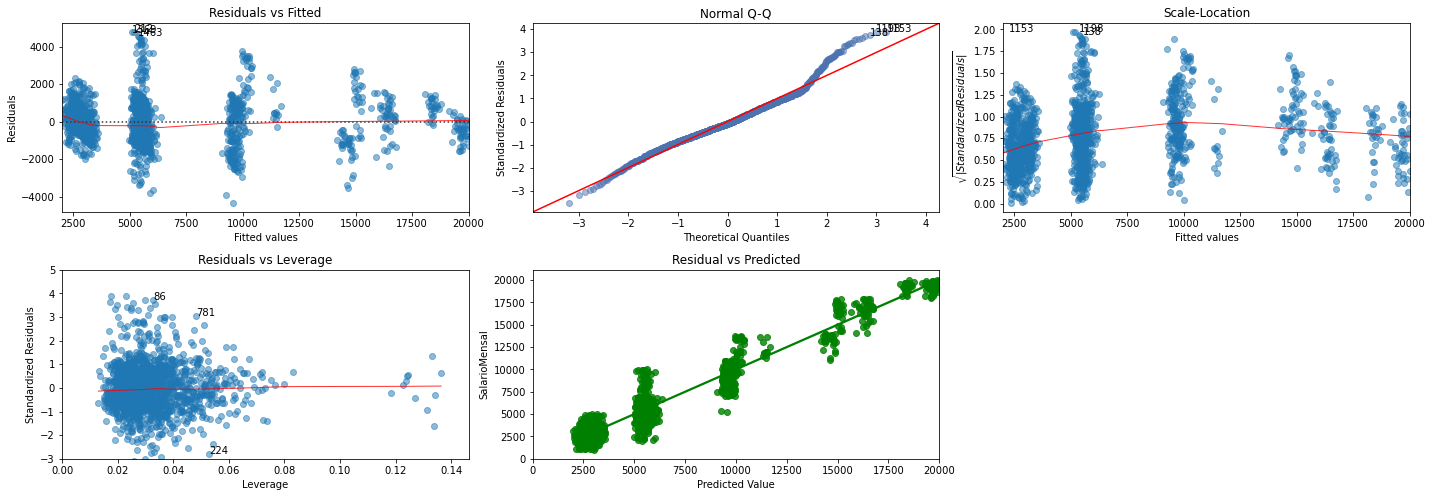

In [8]:
## ANOVA com todas as variáveis categóricas

features_cat = ['ViagemNegocios', 'NivelTrabalho', 'Departmento', 'Atrito',  'CampoEducacao', 'Sexo', 'Funcao', 'EstadoCivil', 'Educacao', 'SatisfacaoAmbiente', 'EnvolvimentoTrabalho', 
                'SatisfacaoTrabalho', 'AvaliacaoPerformance', 'SatisfacaoRelacionamento', 'NivelOpcoesAcoes', 'EquilibrioVidaPessoal']


formula = 'SalarioMensal ~ C(ViagemNegocios) + C(NivelTrabalho) + C(Departmento) + C(Atrito) + C(CampoEducacao) + C(Sexo) + C(Funcao) + C(EstadoCivil) + \
          C(Educacao) + C(SatisfacaoAmbiente) + C(EnvolvimentoTrabalho) + C(SatisfacaoTrabalho) + C(AvaliacaoPerformance) + C(SatisfacaoRelacionamento) + \
          C(NivelOpcoesAcoes) + C(EquilibrioVidaPessoal)'

ANOVA_diagnostics(salarios, features_cat, dep_feature='SalarioMensal', anova_form=formula, ss_type=[1, 3])

Com base no ss1 (Coluna Type I SS) e ss3 (Coluna Type III SS), as variáveis NivelTrabalho, Funcao e Educacao são as mais significativas e usaremos as 3 na próxima versão do modelo

### ANOVA Modelo 2

------ Class Level Information Table ------ 



,Class,Levels,Values
0,NivelTrabalho,5,"[1, 2, 3, 4, 5]"
1,Funcao,8,"[Research, Sales Executive, Laboratory Technician, Manufacturing Director, Healthcare Representative, Manager, Sales Representative, Human Resources]"
2,Educacao,5,"[3, 4, 2, 1, 5]"


,0
Number of Observations Read,1470
Number of Observations Used,1470



------ Dependent Variable: SalarioMensal ------ 

------ Model Statistics ------ 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalarioMensal   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1319.
Date:                Sat, 04 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:12:38   Log-Likelihood:                -12546.
No. Observations:                1470   AIC:                         2.512e+04
Df Residuals:                    1454   BIC:                         2.521e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            2810.9445    171.425     16.398      0.000    2474.678    3147.211
C(NivelTrabalho)[T.2]                2783.4194    109.491     25.421      0.000    2568.643    2998.196
C(NivelTrabalho)[T.3]                6988.8937    130.846     53.413      0.000    6732.226    7245.561
C(NivelTrabalho)[T.4]                1.196e+04    164.458     72.708      0.000    1.16e+04    1.23e+04
C(NivelTrabalho)[T.5]                1.527e+04    196.895     77.545      0.000    1.49e+04    1.57e+04
C(Funcao)[T.Human Resources]           62.5166    214.127      0.292      0.770    -357.514     482.547
C(Funcao)[T.Laboratory Technician]   -129.7121    156.146     -0.831      0.406    -436.007     176.583
C(Funcao)[T.Manager]                 1725.4877    202.119      8.537      0.000    1329.012    2121.963
C(Funcao)[T.Manufacturing Director]  -110.9254    149.459     -0.742      0.458    -404.103     182.253
C(Funcao)[T.Research]                 424.7405    145.149      2.926      0.003     140.016     709.465
C(Funcao)[T.Sales Executive]           37.2696    128.686      0.290      0.772    -215.160     289.699
C(Funcao)[T.Sales Representative]    -308.1778    198.650     -1.551      0.121    -697.848      81.493
C(Educacao)[T.2]                     -221.5347    121.376     -1.825      0.068    -459.625      16.556
C(Educacao)[T.3]                     -182.8366    108.830     -1.680      0.093    -396.317      30.644
C(Educacao)[T.4]                       -5.1113    114.778     -0.045      0.964    -230.260     220.038
C(Educacao)[T.5]                     -182.2864    205.247     -0.888      0.375    -584.898     220.325
==============================================================================
Omnibus:                      114.148   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.257
Skew:                           0.533   Prob(JB):                     1.34e-46
Kurtosis:                       4.520   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


 ------ ANOVA Type 1 SS ------ 


,df,sum_sq,mean_sq,F,PR(>F)
C(NivelTrabalho),4.0,3.012471e+10,7.531179e+09,4911.490360,0.000000e+00
C(Funcao),7.0,1.929601e+08,2.756573e+07,17.977112,4.986743e-23
C(Educacao),4.0,1.296701e+07,3.241754e+06,2.114123,7.679544e-02
Residual,1454.0,2.229534e+09,1.533379e+06,NaN,NaN


------  Most significant variables based on SS ------ 


,df,sum_sq,mean_sq,F,PR(>F)
C(NivelTrabalho),4.0,3.012471e+10,7.531179e+09,4911.490360,0.000000e+00
Residual,1454.0,2.229534e+09,1.533379e+06,NaN,NaN
C(Funcao),7.0,1.929601e+08,2.756573e+07,17.977112,4.986743e-23
C(Educacao),4.0,1.296701e+07,3.241754e+06,2.114123,7.679544e-02



 ------ ANOVA Type 3 SS ------ 


,sum_sq,df,F,PR(>F)
Intercept,4.122927e+08,1.0,268.878448,1.411028e-55
C(NivelTrabalho),1.395102e+10,4.0,2274.554190,0.000000e+00
C(Funcao),1.909884e+08,7.0,17.793411,8.806884e-23
C(Educacao),1.296701e+07,4.0,2.114123,7.679544e-02
Residual,2.229534e+09,1454.0,NaN,NaN


------  Most significant variables based on SS ------ 


,sum_sq,df,F,PR(>F)
C(NivelTrabalho),1.395102e+10,4.0,2274.554190,0.000000e+00
Residual,2.229534e+09,1454.0,NaN,NaN
Intercept,4.122927e+08,1.0,268.878448,1.411028e-55
C(Funcao),1.909884e+08,7.0,17.793411,8.806884e-23
C(Educacao),1.296701e+07,4.0,2.114123,7.679544e-02



------ Diagnostic Plots ------ 


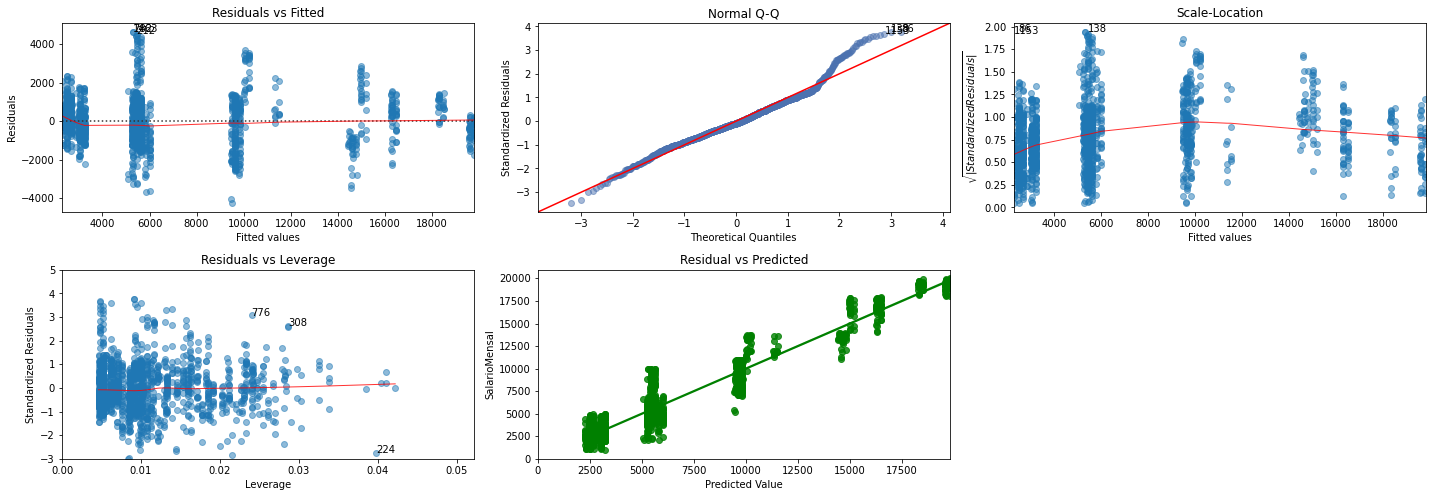

In [9]:
# ANOVA usando variáveis mais significativas do modelo anterior

features_cat = ['NivelTrabalho', 'Funcao', 'Educacao']

formula = 'SalarioMensal ~ C(NivelTrabalho) + C(Funcao) + C(Educacao)'

ANOVA_diagnostics(salarios, features_cat, dep_feature='SalarioMensal', anova_form=formula, ss_type=[1, 3])

## Adjustment for Multiple Comparisons: Tukey-Kramer

Métodos de Comparações Múltiplas

Os Métodos de Comparações Múltiplas (MCMs) são procedimentos estatísticos designados para ter em conta e controlar o aumento da probabilidade global do Erro do Tipo I o u a diminuição do intervalo de confiança global. Os MCMs podem ser categorizados como "etapa única" (single step) ou "por etapas" (stepwise). 

Para os procedimentos de uma etapa, cada uma  das inferências é realizada em uma única etapa, sem referência às outras inferências na família. 

Exemplos de MCMs de uma etapa que protegem a FWER incluem:
    - Teste de Tukey (dados balanceados); 
    - Teste de Tukey-kramer (dados não balanceados);
    - Teste de Dunnet; 
    - Teste de de Scheffe;
    - Teste de Bonferroni.

Fonte:
http://www.portalaction.com.br/anova/teste-de-comparacoes-multiplas <br>
http://www.portalaction.com.br/anova/31-teste-de-tukey

In [10]:
print('NivelTrabalho\n')
pg.pairwise_tukey(data=salarios, dv='SalarioMensal', between='NivelTrabalho', alpha=0.05)

NivelTrabalho



,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,2786.915285,5502.277154,-2715.361868,78.579467,two-sided,-34.555616,0.001,-2.104519
1,1,3,2786.915285,9817.252294,-7030.337008,103.379859,two-sided,-68.004900,0.001,-5.447219
2,1,4,2786.915285,15503.783019,-12716.867733,136.911923,two-sided,-92.883567,0.001,-9.851548
3,1,5,2786.915285,19191.826087,-16404.910802,164.787028,two-sided,-99.552198,0.001,-12.707719
4,2,3,5502.277154,9817.252294,-4314.975140,103.629121,two-sided,-41.638635,0.001,-3.343273
5,2,4,5502.277154,15503.783019,-10001.505865,137.100234,two-sided,-72.950319,0.001,-7.747875
6,2,5,5502.277154,19191.826087,-13689.548933,164.943518,two-sided,-82.995374,0.001,-10.604125
7,3,4,9817.252294,15503.783019,-5686.530725,152.673301,two-sided,-37.246399,0.001,-4.400095
8,3,5,9817.252294,19191.826087,-9374.573793,178.098363,two-sided,-52.637058,0.001,-7.251609
9,4,5,15503.783019,19191.826087,-3688.043068,199.440483,two-sided,-18.491948,0.001,-2.847965


### Educacao

In [11]:
pg.pairwise_tukey(data=salarios, dv='SalarioMensal', between='Educacao')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,5640.570588,6226.645390,-586.074802,455.353643,two-sided,-1.287076,0.499998,-0.124767
1,1,3,5640.570588,6517.263986,-876.693398,409.645407,two-sided,-2.140127,0.203263,-0.186758
2,1,4,5640.570588,6832.402010,-1191.831422,429.671733,two-sided,-2.773819,0.044177,-0.253811
3,1,5,5640.570588,8277.645833,-2637.075245,766.499331,two-sided,-3.440414,0.005298,-0.560379
4,2,3,6226.645390,6517.263986,-290.618596,341.220394,two-sided,-0.851703,0.900000,-0.061917
5,2,4,6226.645390,6832.402010,-605.756620,365.020267,two-sided,-1.659515,0.460666,-0.129029
6,2,5,6226.645390,8277.645833,-2051.000443,732.218015,two-sided,-2.801079,0.040922,-0.436357
7,3,4,6517.263986,6832.402010,-315.138024,306.108176,two-sided,-1.029499,0.499998,-0.067148
8,3,5,6517.263986,8277.645833,-1760.381847,704.702520,two-sided,-2.498050,0.091059,-0.374930
9,4,5,6832.402010,8277.645833,-1445.243823,716.529190,two-sided,-2.017006,0.257840,-0.307665


In [12]:
print('Funcao\n')

'''salarios['Funcao'] = salarios['Funcao'].map({'Research': 1, 
                                            'Sales Executive': 2,
                                            'Laboratory Technician': 3,
                                            'Manufacturing Director': 4,
                                            'Healthcare Representative': 5,
                                            'Manager': 6,
                                            'Sales Representative': 7,
                                            'Human Resources': 8})'''

a = pg.pairwise_tukey(data=salarios, dv='SalarioMensal', between='Funcao')

a

Funcao



,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,Healthcare Representative,Human Resources,7528.763359,4235.750000,3293.013359,546.729467,two-sided,6.023113,0.001000,0.983113
1,Healthcare Representative,Laboratory Technician,7528.763359,3237.169884,4291.593475,357.627602,two-sided,12.000174,0.001000,1.284084
2,Healthcare Representative,Manager,7528.763359,17181.676471,-9652.913112,440.480294,two-sided,-21.914518,0.001000,-2.884432
3,Healthcare Representative,Manufacturing Director,7528.763359,7295.137931,233.625428,402.086182,two-sided,0.581033,0.900000,0.069846
4,Healthcare Representative,Research,7528.763359,5991.279570,1537.483789,338.891855,two-sided,4.536798,0.001000,0.460230
5,Healthcare Representative,Sales Executive,7528.763359,6924.279141,604.484218,345.062615,two-sided,1.751810,0.499998,0.180919
6,Healthcare Representative,Sales Representative,7528.763359,2626.000000,4902.763359,467.968315,two-sided,10.476699,0.001000,1.464589
7,Human Resources,Laboratory Technician,4235.750000,3237.169884,998.580116,506.889036,two-sided,1.970017,0.499998,0.298636
8,Human Resources,Manager,4235.750000,17181.676471,-12945.926471,568.385329,two-sided,-22.776672,0.001000,-3.861865
9,Human Resources,Manufacturing Director,4235.750000,7295.137931,-3059.387931,539.177421,two-sided,-5.674177,0.001000,-0.913639


In [13]:
a[a['A'] == 'Healthcare Representative']

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,Healthcare Representative,Human Resources,7528.763359,4235.750000,3293.013359,546.729467,two-sided,6.023113,0.001000,0.983113
1,Healthcare Representative,Laboratory Technician,7528.763359,3237.169884,4291.593475,357.627602,two-sided,12.000174,0.001000,1.284084
2,Healthcare Representative,Manager,7528.763359,17181.676471,-9652.913112,440.480294,two-sided,-21.914518,0.001000,-2.884432
3,Healthcare Representative,Manufacturing Director,7528.763359,7295.137931,233.625428,402.086182,two-sided,0.581033,0.900000,0.069846
4,Healthcare Representative,Research,7528.763359,5991.279570,1537.483789,338.891855,two-sided,4.536798,0.001000,0.460230
5,Healthcare Representative,Sales Executive,7528.763359,6924.279141,604.484218,345.062615,two-sided,1.751810,0.499998,0.180919
6,Healthcare Representative,Sales Representative,7528.763359,2626.000000,4902.763359,467.968315,two-sided,10.476699,0.001000,1.464589


Podemos perceber que, à medida que o nível de trabalho aumenta, a renda mensal também aumenta.

Os limites de confiança de 95% não incluem 0 nos mínimos quadrados médios para efeito no nível de trabalho.

Quanto à educação, todos os limites de confiança de 95% incluem 0, mas podemos perceber claramente que os níveis 1 e 4 de educação recebem um salário mais alto do que os níveis 2, 3 e 5. da educação.

Nível 1 significa sem curso superior, nível 2 significa nível superior, nível 3 significa nível de bacharel, nível 4 significa nível de mestre e nível 5 significa nível de doutorado.

Com relação à função, podemos perceber que a renda mensal está diminuindo na seguinte ordem: Gerente, Recursos humanos, Pesquisa, Executivo de vendas, Representante da área de saúde, Diretor de fabricação, Técnico de laboratório, Representante de vendas.

Conclusão: Quanto maior o nível educacional e maior o nível funcional, maior o salário. Esses são os fatores (categóricos) que mais impactam no salário de um funcionário.

Além disso e de acordo com o segundo modelo, a variável NivelTrabalho é a que apresenta maior significância. Logo, se quiser ganhar mais, tem que subir na hierarquia.
